# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [157]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


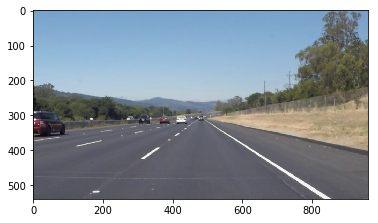

In [158]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [159]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #print("num lines : "+str(len(lines)))
    def mlen(line):
        x1,y1,x2,y2 = line
        return ((x2-x1)**2+(y2-y1)**2)**0.5
    
    def mslope(line):
        x1,y1,x2,y2 = line
        x1,y1,x2,y2 = (x2,y2,x1,y1) if x2<x1 else (x1,y1,x2,y2)
        ret = (y2-y1)*1.0/(x2-x1) if x2!=x1 else None
        if ret is None:
            print("%s is vertical"%(str(line)))
        return ret 
    
    
    def mrho(line):
        x1,y1,x2,y2 = line
        dx = x2-x1
        dy = y2-y1
        l = (dx*dx+dy*dy)**0.5
        rx = x1*(1-(dx/l))
        ry = y1*(1-(dy/l))
        return (rx*rx+ry*ry)**0.5
    
    mlines = [l for line_group in lines for l in line_group if mslope(l)]
    mlens = [mlen(l) for l in mlines]
    mslopes = [mslope(l) for l in mlines]
    mrhos = [mrho(l) for l in mlines]
    mthetas = [math.atan(-1.0/m) for m in mslopes]
    mrho_avg = np.average(mrhos,weights=mlens)
    mslope_avg = np.average(mslopes,weights=mlens)
    
    left_lane_boundary = []
    right_lane_boundary = []
    ignored_line = []
    
    for curline,curlen,curslope,currho in zip(mlines,mlens,mslopes,mrhos):
        if curslope>0: #and currho < mrho_avg:
            right_lane_boundary.append((curline,curlen,curslope,currho))
        elif curslope<0: # and currho > mrho_avg:
            left_lane_boundary.append((curline,curlen,curslope,currho))
        else:
            ignored_line.append((curline,curlen,curslope,currho))
    
    #print('right : '+str(len(right_lane_boundary))+' left : '+str(len(left_lane_boundary))+' ignored : '+str(len(ignored_line)))
    def drawlanelines(lanelines,lanecolor,lanethickness):
        for curline,curlen,curslope,currho in lanelines:
            x1,y1,x2,y2 = curline
            cv2.line(img,(x1,y1),(x2,y2),lanecolor,lanethickness)
    
    def extend_lane_line(avg_slope,avg_rho,ymin=290,ymax=600):
        intercept = avg_rho * m.sqrt(1+avg_slope**2)
        xmin = int((ymin - intercept)/avg_slope);
        xmax = int((ymax - intercept)/avg_slope);
        print(xmin,ymin,xmax,ymax)
        print(avg_slope,avg_rho)
        return [xmin,ymin,xmax,ymax]
    
    def avg_line_params(lane_lines):
        sum_weighted_slope = 0.0
        sum_weighted_rho = 0.0
        sum_weights = 0.0
        for (_,l,m,rho) in lane_lines:
            print(" l :",l," m : ",m," rho : ",rho)
            sum_weighted_slope += m*l
            sum_weighted_rho += rho*l
            sum_weights += l
        (m,rho) = (sum_weighted_slope/sum_weights,sum_weighted_rho/sum_weights)
        print(" m : ",m," rho : ",rho)
        return (m,rho)
    
    def median_line_params(lane_lines):
        for _,l,m,rho in lane_lines:
            print(" l :",l," m : ",m," rho : ",rho)
        return np.median([x[2] for x in lane_lines]),np.median([x[3] for x in lane_lines])
    
    def extend_average_lane_line(lanelines,ymin=290,ymax=600):
        avg_slope,avg_rho = avg_line_params(lanelines)
        extended_line = extend_lane_line(avg_slope,avg_rho,ymin,ymax)
        return [(extended_line,mlen(extended_line),avg_slope,avg_rho)]
        
    def extend_median_lane_line(lanelines,ymin=290,ymax=600):
        avg_slope,avg_rho = median_line_params(lanelines)
        extended_line = extend_lane_line(avg_slope,avg_rho,ymin,ymax)
        return [(extended_line,mlen(extended_line),avg_slope,avg_rho)]
        
    def extend_longest_lane_line(lanelines,ymin=290,ymax=600):
        maxlen = 0
        maxline = None
        for line in lanelines:
            l,clen,cslope,crho = line
            if clen>maxlen:
                maxlen = clen
                maxline = line
        l,clen,cslope,crho = maxline
        x1,y1,x2,y2 = l
        m1 = (x2-x1)/(y2-y1)
        xmin = int(x1-m1*(y1-ymin))
        xmax = int(x1-m1*(y1-ymax))
        return [([xmin,ymin,xmax,ymax],clen,cslope,crho)]
    
    def sort_line(l):
        x1,y1,x2,y2 = l
        if y1<=y2:
            return l
        else:
            return [x2,y2,x1,y1]
  
    def sort_and_join(lanelines,ymin=290,ymax=600):
        lines = [l for l,_,_,_ in lanelines]
        points = []
        for l in lines:
            x1,y1,x2,y2 = l
            points.append((x1,y1))
            points.append((x2,y2))
        
        points = sorted(points,key = lambda p:p[1])
        ret = []
        
        i=0
        while i<len(points)-1:
            ret.append(points[i:i+2])
            i+=1
        return [([p[0][0],p[0][1],p[1][0],p[1][1]],0,0,0) for p in ret]
    
    f = extend_longest_lane_line
    #f = sort_and_join
    #f = extend_average_lane_line
    #f = extend_median_lane_line
    left_lane_boundary = f(left_lane_boundary)
    right_lane_boundary = f(right_lane_boundary)
    
    drawlanelines(left_lane_boundary,[255,0,0],3)
    drawlanelines(right_lane_boundary,[0,255,0],3)
    drawlanelines(ignored_line,[0,0,255],3)
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [160]:
import os
test_images = os.listdir("test_images/")
test_images = ['test_images/'+x for x in test_images]

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

test_images/solidWhiteCurve.jpg
test_images/solidWhiteCurve.jpg
test_images/solidWhiteRight.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowCurve2.jpg
test_images/solidYellowCurve2.jpg
test_images/solidYellowLeft.jpg
test_images/solidYellowLeft.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/whiteCarLaneSwitch.jpg


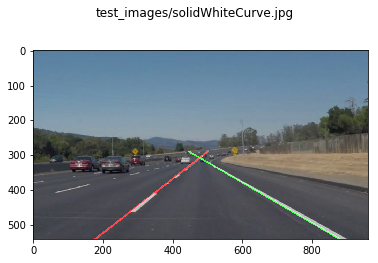

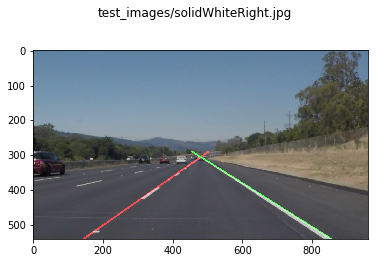

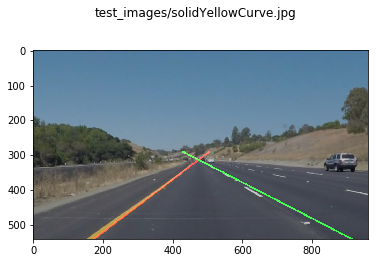

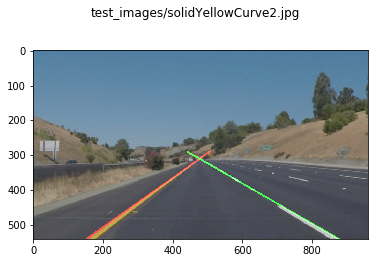

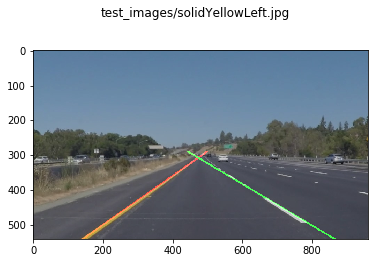

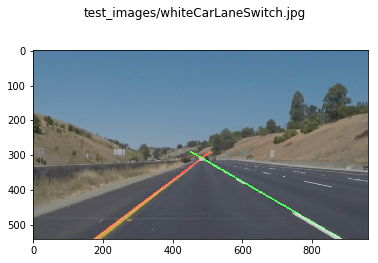

In [161]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def new_image_show(img,caption,**kwargs):
    print(caption);
    fig = plt.figure()
    fig.suptitle(caption)
    plt.imshow(img,**kwargs)
    
def pipeline(img):

    # gaussian
    kernel_size = 3
    # canny
    low_threshold = 100
    high_threshold = 200
    #houghlinesp
    rho = 1
    theta = np.pi/180
    min_votes = 4
    min_length = 20
    max_gap = 10
    #roi
    roi_vertices = np.array([[[100,600],[950,600],[550,290],[450,290]]],dtype=np.int32)
    #new_image_show(img,'input')
    gray_img = grayscale(img)
    #new_image_show(gray_img,'gray',cmap='gray')
    blurred_gray_img = gaussian_blur(gray_img,kernel_size)
    #new_image_show(blurred_gray_img,'after gaussian blurr',cmap='gray')
    blurred_gray_img_canny = canny(blurred_gray_img,low_threshold,high_threshold)
    #new_image_show(blurred_gray_img_canny,'after canny',cmap='gray')
    #blurred_gray_img_canny_with_lines = hough_lines(blurred_gray_img_canny,rho,theta,min_votes,min_length,max_gap)
    #new_image_show(blurred_gray_img_canny_with_lines,'with hough lines')
    blurred_gray_img_canny_with_roi = region_of_interest(blurred_gray_img_canny,roi_vertices)
    blurred_gray_img_canny_with_roi_with_lines = hough_lines(blurred_gray_img_canny_with_roi,rho,theta,min_votes,min_length,max_gap)
    #new_image_show(blurred_gray_img_canny_with_roi,"with hough line in roi")
    #new_image_show(weighted_img(blurred_gray_img_canny_with_roi_with_lines,img),img_path)
    ret = weighted_img(blurred_gray_img_canny_with_roi_with_lines,img)
    return ret 


for img_path in test_images:
    print(img_path)
    img = pipeline(mpimg.imread(img_path))
    new_image_show(img,img_path)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [162]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [163]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [164]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  3%|▎         | 6/222 [00:00<00:03, 58.03it/s]

[436 325 436 303] is vertical



 14%|█▍        | 32/222 [00:00<00:03, 59.90it/s]

[436 325 436 304] is vertical
[436 324 436 302] is vertical



 31%|███       | 68/222 [00:01<00:04, 34.40it/s]

[504 324 504 301] is vertical



 34%|███▍      | 76/222 [00:01<00:04, 33.68it/s]

[436 322 436 302] is vertical



 56%|█████▌    | 124/222 [00:03<00:03, 30.65it/s]

[441 321 441 301] is vertical



 64%|██████▎   | 141/222 [00:04<00:02, 28.42it/s]

[528 312 528 290] is vertical



 78%|███████▊  | 173/222 [00:05<00:01, 30.83it/s]

[537 319 537 295] is vertical
[538 319 538 298] is vertical



 91%|█████████ | 201/222 [00:06<00:00, 33.76it/s]

[445 334 445 307] is vertical



 97%|█████████▋| 216/222 [00:06<00:00, 28.69it/s]

[447 336 447 295] is vertical



100%|█████████▉| 221/222 [00:07<00:00, 31.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.11 s, sys: 1.1 s, total: 4.21 s
Wall time: 7.94 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [165]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [166]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  1%|          | 7/682 [00:00<00:10, 65.20it/s]

[556 326 556 300] is vertical
[531 335 531 312] is vertical
[560 322 560 301] is vertical



  7%|▋         | 50/682 [00:00<00:12, 50.14it/s]

[553 317 553 293] is vertical



 10%|▉         | 65/682 [00:01<00:20, 29.75it/s]

[555 317 555 296] is vertical



 12%|█▏        | 82/682 [00:02<00:25, 23.83it/s]

[558 318 558 297] is vertical



 16%|█▌        | 109/682 [00:03<00:25, 22.86it/s]

[497 315 497 290] is vertical



 17%|█▋        | 119/682 [00:03<00:22, 24.88it/s]

[539 316 539 294] is vertical



 21%|██        | 143/682 [00:05<00:27, 19.84it/s]

[531 319 531 291] is vertical



 22%|██▏       | 149/682 [00:05<00:23, 22.43it/s]

[531 320 531 292] is vertical



 23%|██▎       | 155/682 [00:05<00:26, 20.02it/s]

[543 325 543 296] is vertical



 24%|██▍       | 167/682 [00:06<00:22, 22.40it/s]

[540 301 540 327] is vertical
[541 327 541 301] is vertical



 25%|██▌       | 173/682 [00:06<00:22, 22.49it/s]

[544 321 544 292] is vertical



 28%|██▊       | 189/682 [00:07<00:25, 19.33it/s]

[539 300 539 321] is vertical



 29%|██▉       | 199/682 [00:07<00:20, 23.63it/s]

[512 312 512 290] is vertical



 30%|███       | 208/682 [00:08<00:19, 24.34it/s]

[453 306 453 331] is vertical



 32%|███▏      | 218/682 [00:08<00:20, 23.08it/s]

[451 331 451 303] is vertical



 34%|███▍      | 231/682 [00:08<00:17, 25.33it/s]

[509 294 509 316] is vertical



 36%|███▌      | 245/682 [00:09<00:16, 26.46it/s]

[509 330 509 297] is vertical



 45%|████▌     | 310/682 [00:12<00:14, 26.46it/s]

[501 326 501 303] is vertical



 51%|█████▏    | 351/682 [00:13<00:11, 28.59it/s]

[470 313 470 290] is vertical
[507 332 507 308] is vertical



 55%|█████▌    | 376/682 [00:14<00:10, 28.30it/s]

[489 297 489 324] is vertical



 58%|█████▊    | 397/682 [00:15<00:09, 30.77it/s]

[495 325 495 300] is vertical
[496 326 496 297] is vertical



 60%|██████    | 412/682 [00:15<00:10, 26.92it/s]

[454 325 454 300] is vertical
[454 321 454 299] is vertical



 61%|██████▏   | 419/682 [00:15<00:09, 27.68it/s]

[450 312 450 290] is vertical



 63%|██████▎   | 431/682 [00:16<00:09, 27.79it/s]

[513 318 513 297] is vertical



 67%|██████▋   | 454/682 [00:17<00:08, 27.95it/s]

[511 313 511 292] is vertical



 70%|██████▉   | 476/682 [00:18<00:08, 24.23it/s]

[311 441 311 421] is vertical



 88%|████████▊ | 598/682 [00:22<00:03, 26.38it/s]

[501 326 501 302] is vertical
[501 323 501 300] is vertical



 98%|█████████▊| 667/682 [00:25<00:00, 29.90it/s]

[454 330 454 307] is vertical



100%|█████████▉| 679/682 [00:25<00:00, 27.71it/s]

[454 330 454 307] is vertical



100%|█████████▉| 681/682 [00:25<00:00, 26.45it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.52 s, sys: 1.85 s, total: 11.4 s
Wall time: 26.7 s


In [154]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [155]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  6%|▌         | 15/251 [00:00<00:09, 23.66it/s]

[717 445 717 423] is vertical



  8%|▊         | 21/251 [00:00<00:08, 25.83it/s]

[721 451 721 428] is vertical
[600 423 600 392] is vertical



 16%|█▌        | 39/251 [00:01<00:09, 21.20it/s]

[554 353 554 333] is vertical
[408 384 408 362] is vertical
[552 394 552 427] is vertical
[551 346 551 322] is vertical
[719 450 719 427] is vertical
[581 425 581 397] is vertical



 18%|█▊        | 45/251 [00:01<00:10, 20.09it/s]

[674 430 674 409] is vertical
[534 408 534 428] is vertical



 19%|█▉        | 48/251 [00:02<00:11, 17.03it/s]

[575 404 575 376] is vertical
[640 443 640 422] is vertical



 21%|██        | 52/251 [00:02<00:14, 13.71it/s]

[526 419 526 399] is vertical



 22%|██▏       | 56/251 [00:02<00:15, 12.92it/s]

[513 321 513 300] is vertical



 23%|██▎       | 58/251 [00:03<00:16, 11.80it/s]

[531 313 531 293] is vertical
[434 434 434 401] is vertical



 25%|██▍       | 62/251 [00:03<00:15, 12.04it/s]

[508 426 508 402] is vertical
[514 408 514 376] is vertical
[505 401 505 373] is vertical



 25%|██▌       | 64/251 [00:03<00:17, 10.52it/s]

[446 317 446 296] is vertical
[427 415 427 391] is vertical
[378 383 378 362] is vertical
[527 343 527 311] is vertical
[434 399 434 367] is vertical



 27%|██▋       | 68/251 [00:03<00:15, 11.61it/s]

[489 313 489 290] is vertical
[426 361 426 384] is vertical
[407 350 407 328] is vertical



 28%|██▊       | 70/251 [00:04<00:16, 10.84it/s]

[457 342 457 376] is vertical
[461 394 461 354] is vertical
[398 388 398 366] is vertical



 29%|██▊       | 72/251 [00:04<00:17, 10.41it/s]

[469 569 469 549] is vertical



 30%|███       | 76/251 [00:04<00:14, 11.85it/s]

[413 391 413 359] is vertical
[367 456 367 431] is vertical
[414 396 414 355] is vertical
[401 339 401 365] is vertical
[430 350 430 328] is vertical
[389 349 389 379] is vertical
[306 442 306 418] is vertical
[483 423 483 449] is vertical



 32%|███▏      | 80/251 [00:04<00:13, 12.30it/s]

[620 441 620 391] is vertical
[464 451 464 425] is vertical
[635 437 635 408] is vertical
[466 368 466 348] is vertical



 33%|███▎      | 84/251 [00:05<00:13, 12.55it/s]

[463 367 463 346] is vertical
[466 455 466 427] is vertical
[465 455 465 427] is vertical
[606 443 606 419] is vertical
[372 460 372 432] is vertical
[365 463 365 434] is vertical



 35%|███▌      | 88/251 [00:05<00:12, 13.47it/s]

[620 423 620 398] is vertical
[346 465 346 438] is vertical
[629 430 629 408] is vertical
[444 378 444 356] is vertical



 37%|███▋      | 92/251 [00:05<00:11, 14.18it/s]

[441 456 441 432] is vertical
[442 344 442 315] is vertical
[443 450 443 421] is vertical
[501 319 501 292] is vertical
[382 472 382 446] is vertical
[441 437 441 458] is vertical
[437 365 437 345] is vertical



 37%|███▋      | 94/251 [00:06<00:12, 12.75it/s]

[430 460 430 427] is vertical
[432 460 432 434] is vertical
[417 462 417 428] is vertical
[432 339 432 312] is vertical
[431 460 431 428] is vertical
[429 337 429 316] is vertical
[436 420 436 445] is vertical
[351 471 351 433] is vertical
[475 451 475 423] is vertical
[426 337 426 311] is vertical
[427 349 427 328] is vertical
[473 451 473 423] is vertical
[427 460 427 428] is vertical
[351 456 351 432] is vertical



 39%|███▉      | 98/251 [00:06<00:14, 10.42it/s]

[421 349 421 370] is vertical
[266 465 266 485] is vertical
[276 487 276 448] is vertical



 41%|████      | 102/251 [00:06<00:13, 11.31it/s]

[596 430 596 395] is vertical
[534 434 534 411] is vertical
[402 448 402 428] is vertical



 41%|████▏     | 104/251 [00:06<00:12, 11.63it/s]

[504 418 504 447] is vertical
[478 443 478 423] is vertical
[455 455 455 428] is vertical


 44%|████▍     | 110/251 [00:07<00:11, 12.69it/s]


[559 437 559 409] is vertical
[430 429 430 449] is vertical
[487 331 487 351] is vertical
[546 436 546 409] is vertical



 45%|████▌     | 114/251 [00:07<00:10, 13.69it/s]

[278 466 278 445] is vertical
[536 433 536 396] is vertical
[545 427 545 407] is vertical
[557 320 557 297] is vertical
[400 438 400 415] is vertical



 46%|████▌     | 116/251 [00:07<00:10, 12.49it/s]

[454 445 454 425] is vertical
[548 319 548 293] is vertical



 48%|████▊     | 120/251 [00:08<00:10, 12.32it/s]

[409 460 409 439] is vertical
[431 328 431 308] is vertical



 49%|████▊     | 122/251 [00:08<00:11, 11.00it/s]

[294 480 294 436] is vertical



 50%|█████     | 126/251 [00:08<00:11, 11.18it/s]

[484 334 484 365] is vertical
[479 356 479 335] is vertical
[478 363 478 330] is vertical
[442 439 442 418] is vertical



 51%|█████     | 128/251 [00:09<00:11, 11.01it/s]

[468 419 468 439] is vertical
[377 452 377 427] is vertical
[478 446 478 414] is vertical
[306 475 306 445] is vertical



 53%|█████▎    | 132/251 [00:09<00:10, 11.70it/s]

[352 448 352 428] is vertical
[446 454 446 428] is vertical
[438 405 438 430] is vertical
[313 433 313 411] is vertical
[468 364 468 386] is vertical
[425 402 425 382] is vertical



 54%|█████▍    | 136/251 [00:09<00:10, 11.27it/s]

[408 411 408 388] is vertical
[536 427 536 407] is vertical


 65%|██████▌   | 164/251 [00:12<00:06, 12.63it/s]


[358 393 358 371] is vertical
[453 427 453 402] is vertical



 75%|███████▍  | 188/251 [00:14<00:05, 11.41it/s]

[459 559 459 582] is vertical



 84%|████████▎ | 210/251 [00:16<00:03, 11.45it/s]

[557 321 557 295] is vertical



 96%|█████████▌| 240/251 [00:18<00:00, 11.19it/s]

[662 430 662 405] is vertical
[650 434 650 408] is vertical



100%|██████████| 251/251 [00:19<00:00, 12.66it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 8.1 s, sys: 2.43 s, total: 10.5 s
Wall time: 22.3 s


In [167]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))